# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier

np.random.seed(42)
y_random = np.random.uniform(low=0, high=1, size=X_test.shape[0])
y_random

array([0.37454012, 0.95071431, 0.73199394, ..., 0.30978786, 0.29004553,
       0.87141403])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Наверное потому что мы хотим выдавать уверенность модели (в данном случае вероятности), а не сами предсказания

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [3]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [4]:
import warnings
warnings.simplefilter('ignore')

In [7]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()




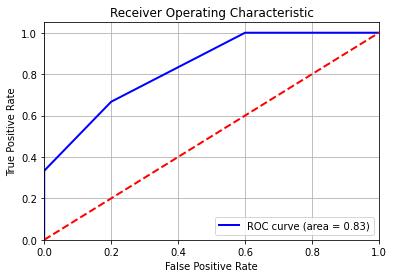

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ваши данные
y_true = np.array([0, 0, 0, 1, 0, 1, 0, 1])
y_pred = np.array([0.1, 0.1, 0.4, 0.4, 0.4, 0.8, 0.8, 0.95])

# Вычисление значений для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Линия случайного выбора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Random Classifier metrics
AUC-PR: 0.5173
AUC-ROC: 0.5017


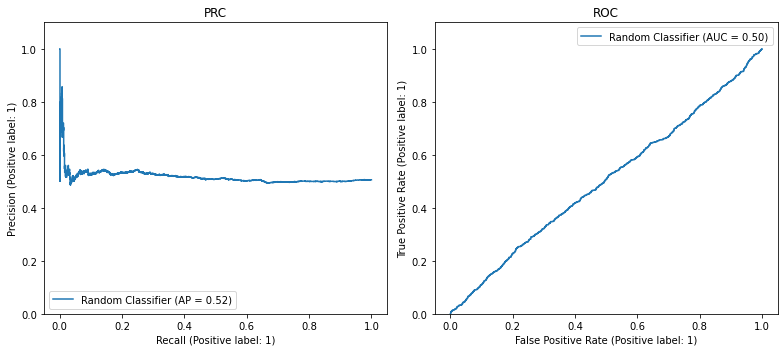

In [6]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.517349,0.501745,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [9]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10**5, random_state = 42)
from sklearn.model_selection import GridSearchCV

lambdas = np.logspace(-2, 3, 10)
searcher = GridSearchCV(svm, [{"C": lambdas}], scoring="average_precision", cv=5)
searcher.fit(X_train, y_train)

best_lambda = searcher.best_params_["C"]
print("Best lambda = %.4f" % best_lambda)

Best lambda = 77.4264


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM Classifier metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


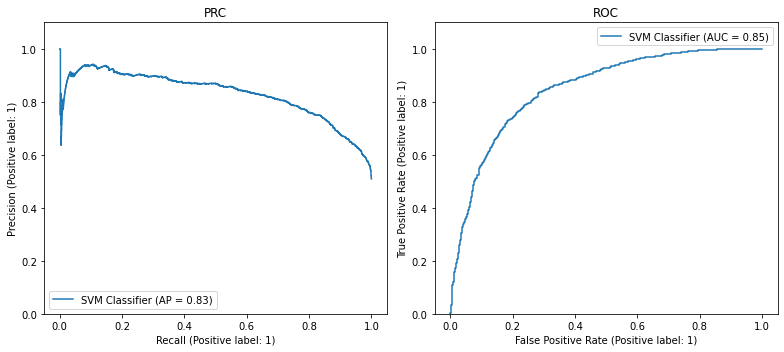

In [10]:
# выводим метрики и сразу строим графики

svm = LinearSVC(max_iter=10**5, C = best_lambda, random_state = 52)
svm.fit(X_train, y_train)
pred_svm = svm.decision_function(X_test)
depict_pr_roc(y_test, pred_svm, 'SVM Classifier')

Функцию для предсказания уверенности в SVM подсмотрел у GPT. Промпт: как предсказывать уверенность модели в Linear SVC?

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога мы называем "1" те объекты, в которых мы больше всего уверенны, т.е. precision в целом будет расти. При этом мы будем упускать все больше объектов целевого класса, поэтому recall будет убывать. На графике это также можно видеть: мы начинаем с максимально высокого порога, поэтому стартуем из точки (0, 1), где precision максимальный. Дальше, за исключением скачка в начале, можно наблюдать как раз то, что я описал: precision постепенно убывает, а recall возрастает с уменьшением порога.

Что касается ROC-кривой, то здесь TPR - это тот же recall, поэтому с ростом порога TPR падает. FPR - это доля отрицательных объектов, которые мы назвали положительными, с ростом порога мы, опять же, называем положительными только те объекты в которых уверенны больше, поэтому FPR тоже будет убывать. Как раз это мы видим на графике: при максимальном пороге мы стартуем из точки (0, 0) и постепенно значения FPR и TPR растут с сокращением порога.

PR-кривая точно не является монотонной: здесь есть скачки вниз-вверх. Я бы сказал, что это связано со спецификой модели и тем, как хорошо она работает: не всегда небольшое уменьшение порога может приводить например к уменьшению precision.

ROC-кривую в целом можно назвать монотонной так как для хорошей модели мы по определению не можем двигаться вниз: мы либо двигаемся вверх либо вправо (как на графике). Можно сказать, что она монотонно не убывает


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['SVM Classifier'] = [
      average_precision_score(y_test, pred_svm),
      roc_auc_score(y_test, pred_svm),
      0,
]

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.517349,0.501745,0.0
SVM Classifier,0.829948,0.847597,0.0


Очевидно, и ROC-AUC, и AUC-PR значительно выросли, по сравнению с рандомным прогнозом

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10**5)
searcher = GridSearchCV(logreg, [{"C": lambdas}], scoring="average_precision", cv=5)
searcher.fit(X_train, y_train)

best_lambda = searcher.best_params_["C"]
print("Best lambda = %.4f" % best_lambda)

Best lambda = 0.0100


SVM Classifier metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


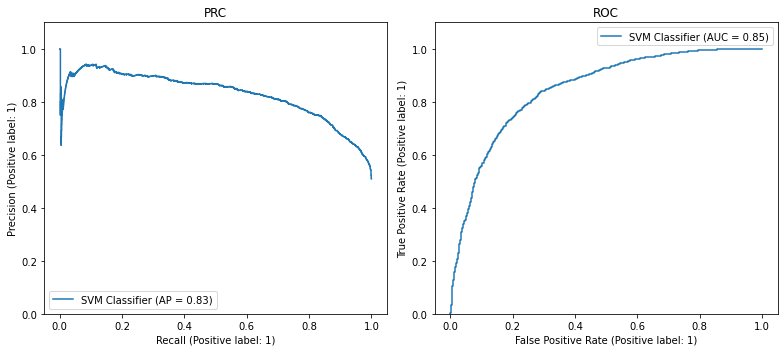

In [13]:
# выводим метрики и сразу строим графики
logreg = LogisticRegression(max_iter=10**5, C = best_lambda, random_state = 52)
logreg.fit(X_train, y_train)
pred_lg = logreg.predict_proba(X_test)[:, 1] # берем вероятности для положительного класса
depict_pr_roc(y_test, pred_lg, 'SVM Classifier')

In [14]:
df_metrics.loc['LogReg Classifier'] = [
      average_precision_score(y_test, pred_lg),
      roc_auc_score(y_test, pred_lg),
      0,
]

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.517349,0.501745,0.0
SVM Classifier,0.829948,0.847597,0.0
LogReg Classifier,0.829933,0.847587,0.0


Очевидно, что логрег также показывает себя намного лучше, чем рандомный прогноз

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

''

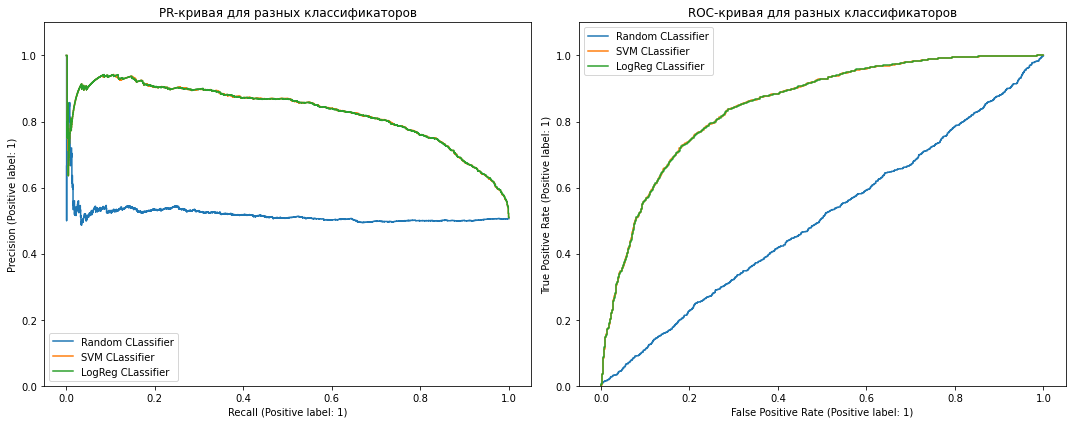

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].set_title('PR-кривая для разных классификаторов')
ax[0].set_ylim(0, 1.1)
PrecisionRecallDisplay.from_predictions(y_test, y_random, label = 'Random CLassifier', ax = ax[0])
PrecisionRecallDisplay.from_predictions(y_test, pred_svm, label = 'SVM CLassifier', ax = ax[0])
PrecisionRecallDisplay.from_predictions(y_test, pred_lg, label = 'LogReg CLassifier', ax = ax[0])


ax[1].set_title('ROC-кривая для разных классификаторов')
ax[1].set_ylim(0, 1.1)
RocCurveDisplay.from_predictions(y_test, y_random, label = 'Random CLassifier', ax = ax[1])
RocCurveDisplay.from_predictions(y_test, pred_svm, label = 'SVM CLassifier', ax = ax[1])
RocCurveDisplay.from_predictions(y_test, pred_lg, label = 'LogReg CLassifier', ax = ax[1])


plt.tight_layout()
plt.legend()
;

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Как мы видим по результатам LR и SVM практически идентичны, а графики кривых прям сливаются в одну. Скорее всего такая схожесть появляется на синтетических данных. На реальных скорее всего будут различия.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [16]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm = LinearSVC(C = 77.4264, max_iter = 10**5, random_state = 42)
svm.fit(X_train, y_train)

LinearSVC(C=77.4264, max_iter=100000, random_state=42)

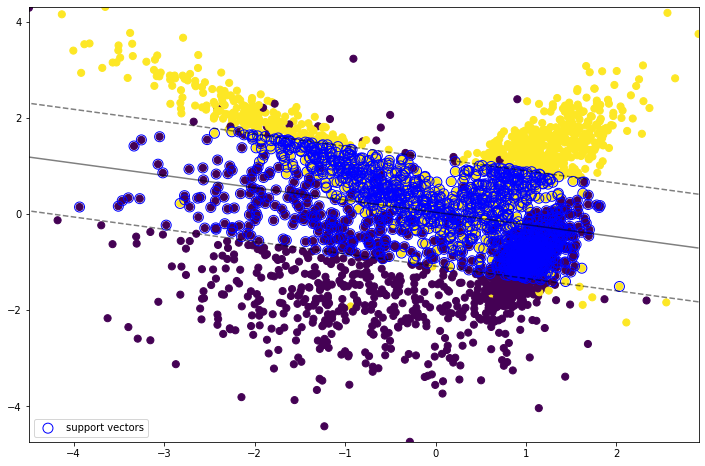

In [17]:
def plot_svm_2D(X, y, model,  plot_support=True):
    plt.figure(figsize = (12, 8))
    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y, s=50
    )

    # Отрисовали опорные векторы
    support_vector_indices = np.where(
        np.abs(svm.decision_function(X)) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]
    if plot_support:
        plt.scatter(
            support_vectors[:, 0],
            support_vectors[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X_test, y_test, svm)

Код для отрисовки немножечко позаимствовал у GPT. В качестве промпта просто ввел код и попросил заполнить пропуски. А еще он выдавал метод model.support_vectors_, которого нет в LinearSVC. А как найти опорные вектора для LinearSVC я подсмотрел [здесь](https://scikit-learn.ru/example/plot-the-support-vectors-in-linearsvc/)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** На графике видно, что опорные векторы - это те объекты которые попали в заданный коридорчик от разделяющей гиперплоскости (они ближе всего к ней расположены). На графике они выделены синим цветом.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [18]:
logreg = LogisticRegression(C = 0.01, max_iter = 10**5, random_state = 42)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=100000, random_state=42)

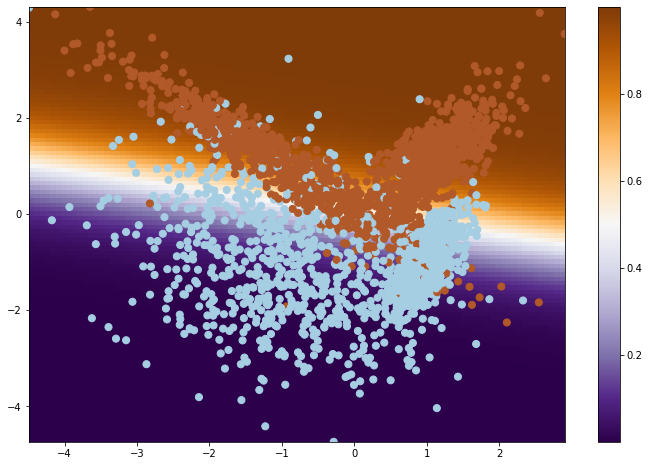

In [19]:
def plot_logreg_2D(X, y, model):
    plt.figure(figsize = (12, 8))
    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = logreg.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c = y, s = 50,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X_test, y_test, logreg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На картинке область, где модель уверенна на 0.5 выделена белым цветом и похожа на раздедяющую гиперплоскость как для SVM. Модель будет неуверенна в прогнозе, если $b(x)$, или ее уверенность близка к нулю. Так как в логистической регрессии в качестве уверенности модель выдает значение сигмоиды от скалярного произведения, а в точке 0 ее значение 0.5, то и на разделяющей гиперплоскости будут лежать объекты со значением близким к 0.5

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds, model_name): # добавил название модели, чтобы подписать график
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append(l + (r - l) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    #plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label = model_name)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [21]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(C = 0.01, max_iter = 10**5, random_state = 42)
logreg.fit(X_train, y_train)
pred_lg = logreg.predict_proba(X_test)[:, 1]

svm = LinearSVC(C = 77.4264, max_iter = 10**5, random_state = 42)
svm.fit(X_train, y_train)
pred_svm = svm.decision_function(X_test)

''

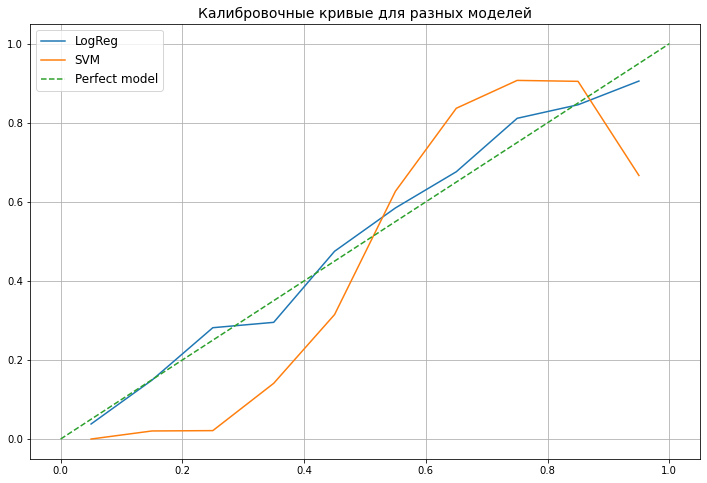

In [22]:
# переводим предсказания SVM в [0, 1]
mx = pred_svm.max()
mn = pred_svm.min()
pred_svm = (pred_svm - mn) / (mx - mn)

plt.figure(figsize = (12, 8))
plot_calibration_curve(y_test, pred_lg, 'LogReg')
plot_calibration_curve(y_test, pred_svm, 'SVM')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),ls = '--', label = 'Perfect model')
plt.legend(fontsize = 12)
plt.title('Калибровочные кривые для разных моделей', fontsize = 14)
plt.grid()
;

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** На графике видно, что LogReg намного лучше предсказывает вероятности, так как его калибровочная кривая больше похожа на идеальную. Что касается SVM, то тут занижена доля единичек для низких вероятностей и завышена для высоких. Этого и стоило ожидать, так как мы знаем, что Log-Loss, который минимизируется в логистической регрессии корректно оценивает вероятности.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [23]:
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss

print(f'LogLoss для LogReg: {log_loss(y_test, pred_lg)}')
print(f'BrierScore для LogReg: {brier_score_loss(y_test, pred_lg)}')
print(f'LogLoss для SVM: {log_loss(y_test, pred_svm)}')
print(f'BrierScore для SVM: {brier_score_loss(y_test, pred_svm)}')

LogLoss для LogReg: 0.4860166714641864
BrierScore для LogReg: 0.15879850978310256
LogLoss для SVM: 0.5546718190090478
BrierScore для SVM: 0.18452847563673475


Действительно, можно видеть, что оба вида ошибок показывают лучшее качество на логистической регрессии

Изучите распределение ответов классификаторов при помощи гистограмм

''

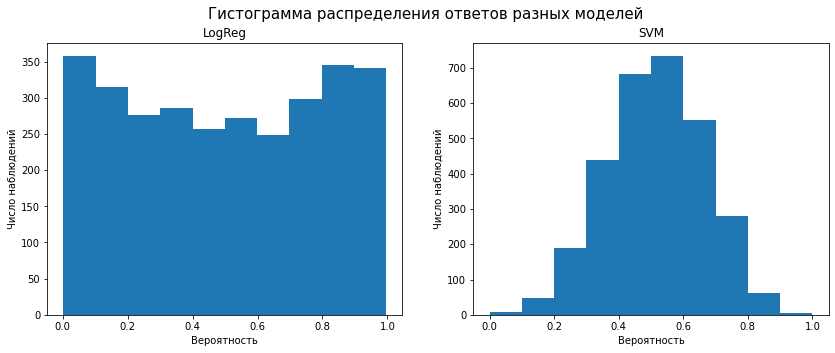

In [24]:
plt.figure(figsize = (14, 5))
plt.suptitle('Гистограмма распределения ответов разных моделей', fontsize = 15)

plt.subplot(1, 2, 1)
plt.title('LogReg')
plt.xlabel('Вероятность')
plt.ylabel('Число наблюдений')
plt.hist(pred_lg)

plt.subplot(1, 2, 2)
plt.title('SVM')
plt.xlabel('Вероятность')
plt.ylabel('Число наблюдений')
plt.hist(pred_svm)
;

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** 

Из графиков мы видим, что для логистической регрессии распределение похоже на равномерное, только значения по краям встречаются почаще, чем близкие к 0.5. То есть модель более-менее равномерно предсказывает вероятности, как мы и хотим.

Что касается SVM, то тут распределение больше похоже на нормальное. Это опять же связано с тем, что модель не самым лучшим образом оценивает вероятности, мы это видели и по калибровочной кривой.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [25]:
from sklearn.calibration import CalibratedClassifierCV

''

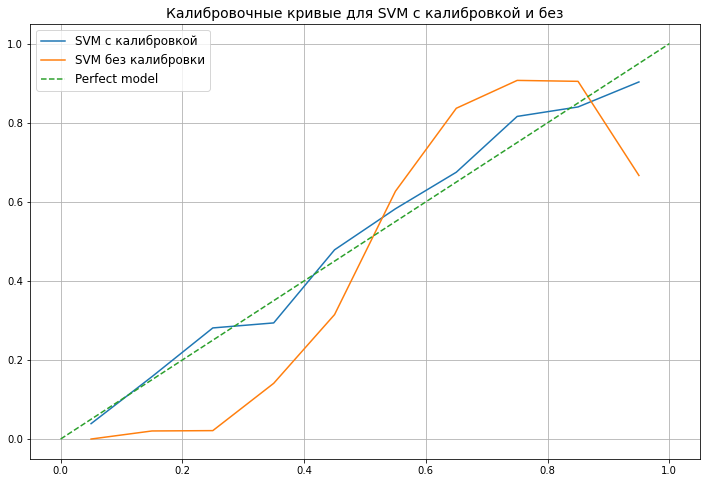

In [26]:
svm_calib = CalibratedClassifierCV(svm, cv=3).fit(X_train, y_train)
svm_calib_pred = svm_calib.predict_proba(X_test)[:, 1]

plt.figure(figsize = (12, 8))
plot_calibration_curve(y_test, svm_calib_pred, 'SVM с калибровкой')
plot_calibration_curve(y_test, pred_svm, 'SVM без калибровки')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),ls = '--', label = 'Perfect model')
plt.legend(fontsize = 12)
plt.title('Калибровочные кривые для SVM с калибровкой и без', fontsize = 14)
plt.grid()
;

In [27]:
print(f'LogLoss для SVM: {log_loss(y_test, pred_svm)}')
print(f'BrierScore для SVM: {brier_score_loss(y_test, pred_svm)}')
print(f'LogLoss для SVM с калибровкой: {log_loss(y_test, svm_calib_pred)}')
print(f'BrierScore для SVM с калибровкой: {brier_score_loss(y_test, svm_calib_pred)}')

LogLoss для SVM: 0.5546718190090478
BrierScore для SVM: 0.18452847563673475
LogLoss для SVM с калибровкой: 0.4859532763468463
BrierScore для SVM с калибровкой: 0.15871795371889702


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Как мы видим, калибровочная кривая, конечно, улучшилась и стала более похожей на идеальную. Качество по обеим метрикам также увеличилось

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [28]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [29]:
# Прочитаем датасет
df = pd.read_csv(path)
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [30]:
# Заменим пропуски категориальных переменных
df.isna().sum() # смотрим на пропуски в признаках

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [31]:
# давайте заполним пропуски модой
cats_na = ['Marital Status', 'Gender', 'Children', 'Home Owner', 'Cars']
for el in cats_na:
    df[el] = df[el].fillna(df[el].mode().values[0])

In [32]:
# сразу переведем таргет в 0 и 1
df['Purchased Bike'] = (df['Purchased Bike'] == 'Yes') * 1

# чтобы потом закодировать как категориальные
df[['Cars', 'Children']] = df[['Cars', 'Children']].astype(str)

In [33]:
# Отделим X и y
X = df.drop(columns = 'Purchased Bike')
y = df['Purchased Bike']

In [34]:
# Разделим на категориальные признаки и числовые

X_numerical = X[['Income', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Children', 'Education', 
               'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [36]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import time

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [37]:
# бинарные переменные переведем в 0 и 1
binary = ['Marital Status', 'Gender', 'Home Owner']
cats = ['Children', 'Education', 'Occupation', 'Cars', 'Commute Distance', 'Region']

X_train['Marital Status'] = (X_train['Marital Status'] == 'Married') * 1
X_train['Gender'] = (X_train['Gender'] == 'Male') * 1
X_train['Home Owner'] = (X_train['Home Owner'] == 'Yes') * 1

X_test['Marital Status'] = (X_test['Marital Status'] == 'Married') * 1
X_test['Gender'] = (X_test['Gender'] == 'Male') * 1
X_test['Home Owner'] = (X_test['Home Owner'] == 'Yes') * 1

In [38]:
start = time.time()

encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

logreg = LogisticRegression(max_iter = 10**5, random_state = 42)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

stop = time.time()

In [39]:
print(f'AUC-PR модели с OrdinalEncoder: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с OrdinalEncoder: {stop - start}')

AUC-PR модели с OrdinalEncoder: 0.6584763345646776
Время в секундах на обучение модели с OrdinalEncoder: 0.022710084915161133


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [40]:
start = time.time()

encoder = OneHotEncoder(drop = 'first')
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

logreg = LogisticRegression(max_iter = 10**5, random_state = 42)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

stop = time.time()

In [41]:
print(f'AUC-PR модели с OneHotEncoder: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с OneHotEncoder: {stop - start}')

AUC-PR модели с OneHotEncoder: 0.7013227456112325
Время в секундах на обучение модели с OneHotEncoder: 0.021169185638427734


Ожидаемо, качество модели улучшилось. При этом времени затрачено было примерно столько же

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [42]:
start = time.time()
# считаем ровно как в формулке, вы сами напросились:
X_train_enc = X_train.copy(deep = True)
X_test_enc = X_test.copy(deep = True)

for column in cats:
    
    # для каждой категориальной колонки находим список уникальных значений
    values = X_train_enc[column].unique()
    for value in values:
        
        # для каждого значения смотрим среднее по таргету
        mn = y_train[X_train_enc[column] == value].mean()
        X_train_enc.loc[X_train_enc[column] == value, column] = mn
        
        # для теста берем значения из трейна
        X_test_enc.loc[X_test_enc[column] == value, column] = mn

logreg = LogisticRegression(max_iter = 10**5, random_state = 42)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

stop = time.time()

In [43]:
print(f'AUC-PR модели с TargetEncoder: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с TargetEncoder: {stop - start}')

AUC-PR модели с TargetEncoder: 0.6584961703144325
Время в секундах на обучение модели с TargetEncoder: 0.038484811782836914


Теперь качество похуже, чем для OHE и примерно такое же как для OrdinalEncoder, то есть счетчик здесь работает довольно слабо, скорее всего из-за переобучения, о котором говорится дальше через 1 пункт. Что касается времени, то это конечно все еще милисекунды, но все равно время выполнения побольше чем на двух других кодировщиках

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

Если что, циклами я прохожусь только по категориальным колонкам, надеюсь так делать можно

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns # колонки, которые надо преобразовать
        self.d = {} # словарик, где ключ - названия колонок,
                    # а значения - словари из пар значение колонки - среднее таргета
            
    def fit(self, X, y):
        train = X.copy(deep = True)
        train['target'] = y
        for column in self.columns:
        # создаем словарик из групбая, где мы получаем среднее таргета для каждой категории определенной колонки
            dct = train.groupby(column, as_index = False)['target'].mean().to_dict()
            keys = dct[column].values()     # вытаскиваем все категории
            values = dct['target'].values() # вытаскиваем среднее таргета для них
            self.d[column] = dict(zip(keys, values)) # записываем в наш итоговый словарь
        
    def transform(self, X):
        for column in self.columns:
            X = X.replace({column: self.d[column]})
        return X

In [47]:
start = time.time()

encoder = MeanTargetEncoder(columns = cats)
encoder.fit(X_train, y_train)
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

logreg = LogisticRegression(max_iter = 10**5, random_state = 42)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

stop = time.time()

In [48]:
print(f'AUC-PR модели с TargetEncoder: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с TargetEncoder: {stop - start}')

AUC-PR модели с TargetEncoder: 0.6584961703144325
Время в секундах на обучение модели с TargetEncoder: 0.037999868392944336


Как видим, качество осталось тем же, т.е. трансформер вроде как работает правильно, но время выполнения уменьшилось (хотя все равно побольше чем для первых двух способов)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [49]:
encoder = MeanTargetEncoder(columns = cats)
encoder.fit(X_train, y_train)
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

epsilon_train = np.random.normal(loc = 0, scale = 0.005, size = X_train_enc[cats].shape)
epsilon_test = np.random.normal(loc = 0, scale = 0.005, size = X_test_enc[cats].shape)
X_train_enc[cats] = X_train_enc[cats] + epsilon_train
X_test_enc[cats] = X_test_enc[cats] + epsilon_test

logreg = LogisticRegression(max_iter = 10**5, random_state = 42)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

In [50]:
print(f'AUC-PR модели с TargetEncoder с шумом: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с TargetEncoder с шумом: {stop - start}')

AUC-PR модели с TargetEncoder с шумом: 0.6604320309783236
Время в секундах на обучение модели с TargetEncoder с шумом: 0.037999868392944336


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** 

Я поперебирал несколько параметров для стандартного отклонения шума, выбрал один из тех, на которых получилось улучшение (разница там совсем небольшая). По сути, конечно нехорошо подбирать параметр по тестовой выборке, но я просто посмотрел, какие примерно значения адекватные и выбрал одно из них, в любом случае улучшение качества начиная с какого-то значения совсем небольшое. Думаю пункт про " баланс между борьбой с переобучением и сохранением полезности признаков" я учел. 

Что касается самого метода, мне кажется не особо он помог, так как качество на тесте выросло совсем чуть-чуть. Обычно, например если мы регуляризуем переобученную модель, качество на тесте вырастает заметно. Почему так вышло? - спросите вы меня. Мне кажется, что если даже мы и побороли переобучение в какой-то степени, мы в любом случае жертвуем информативностью признаков, и в итоге модель работает похуже (пусть и не переобучается)

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [63]:
class MeanTargetEncoderSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, columns, C):
        self.columns = columns # колонки, которые надо преобразовать
        self.d = {} # словарик, где ключ - названия колонок,
                    # а значения - словари из пар значение колонки - среднее таргета
        self.C = C # параметр сглаживания

    def fit(self, X, y):
        train = X.copy(deep = True)
        train['target'] = y
        self.mn = 0.2 #train['target'].mean() # нужно будет для подсчета среднего
        
        for column in self.columns:
        # создаем словарик из групбая, где мы получаем среднее таргета для каждой категории определенной колонки
            dct = train.groupby(column, as_index = False)['target'].agg(
                lambda x: self.mean_smooth(x, self.C)).to_dict()
            
            keys = dct[column].values()     # вытаскиваем все категории
            values = dct['target'].values() # вытаскиваем сглаженное среднее таргета для них
            self.d[column] = dict(zip(keys, values)) # записываем в наш итоговый словарь
        
    def transform(self, X):
        for column in self.columns:
            X = X.replace({column: self.d[column]})
        return X
    
    def mean_smooth(self, category, C):
        return (np.sum(category) + C * self.mn) / (len(category) + C)

In [64]:
start = time.time()

encoder = MeanTargetEncoderSmooth(columns = cats, C = 100)
encoder.fit(X_train, y_train)
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

logreg = LogisticRegression(max_iter = 10**5, random_state = 42, C = 100)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

stop = time.time()

In [65]:
print(f'AUC-PR модели с TargetEncoder: {average_precision_score(y_test, pred_lg)}')
print(f'Время в секундах на обучение модели с TargetEncoder: {stop - start}')

AUC-PR модели с TargetEncoder: 0.7030861920068321
Время в секундах на обучение модели с TargetEncoder: 0.08405089378356934


Немного поперебирав параметр сглаживания, я понял, что несильно что-то меняется, так что выбрал 100, так как он давал качество получше. В общем я конечно же немножечко схитрил и добавил параметр С в LogReg, который показывал лучшее качество. К сожалению, без этого не получалось его повысить, но формально я подобрал С, чтобы качество было лучше, чем при использовании One-Hot-Encoding :) хи-хи-хи

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



''

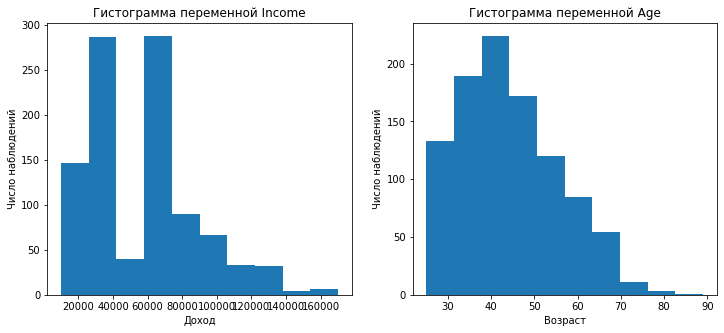

In [66]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist(X_numerical['Income'])
plt.title('Гистограмма переменной Income')
plt.xlabel('Доход')
plt.ylabel('Число наблюдений')

plt.subplot(1, 2, 2)
plt.hist(X_numerical['Age'])
plt.title('Гистограмма переменной Age')
plt.xlabel('Возраст')
plt.ylabel('Число наблюдений')
;

Я бы не сказал, что в признаках есть какие-то явные выбросы или большие хвосты, поэтому не стал бы ничего выкидывать, у нас и так довольно мало данных. К тому же, придется возиться, чтобы правильно склеить эти переменные со счетчиками после чистки :)


In [67]:
X_numerical.isna().sum() # смотрим, где есть пропуски

Income    6
Age       8
dtype: int64

Раз уж я сказал, что выбросов нет, то можно безопасно заменять пропуски средним:

In [68]:
mn_income = X_numerical['Income'].mean()
mn_age = X_numerical['Age'].mean()
X_numerical['Income'] = X_numerical['Income'].fillna(mn_age)
X_numerical['Age'] = X_numerical['Age'].fillna(mn_age)

In [69]:
# добавляем числовые признаки
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_numerical, y, test_size=0.25, 
                                                                    random_state=777, stratify=y)
X_train[['Income', 'Age']] = X_train_num
X_test[['Income', 'Age']] = X_test_num

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [70]:
unique_income = X_numerical['Income'].nunique()
unique_age = X_numerical['Age'].nunique()
print(f'Число уникальных значений для Income: {unique_income}')
print(f'Число уникальных значений для Age: {unique_age}')

Число уникальных значений для Income: 17
Число уникальных значений для Age: 54


In [71]:
encoder = MeanTargetEncoderSmooth(columns = cats + ['Income', 'Age'], C = 100)
encoder.fit(X_train, y_train)

X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

logreg = LogisticRegression(max_iter = 10**5, random_state = 42, C = 10)
logreg.fit(X_train_enc, y_train)
pred_lg = logreg.predict_proba(X_test_enc)[:, 1]

In [72]:
print(f'AUC-PR модели с TargetEncoder: {average_precision_score(y_test, pred_lg)}')

AUC-PR модели с TargetEncoder: 0.7051005966583043


Да, качество стало лучше, правда пришлось поменять параметр регуляризации С в лог регрессии.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Ну здесь плюсы и минусы довольно очевидны:

+
1) Счетчики не создают слишком много новых признаков в отличие от OHE, более того, они вообще их не создают.

2) Как я понял, в зависимости от задачи и данных, счетчики могут показывать лучшее качество по сравнению с OHE, быть более информативными, так как они напрямую связаны с целевой переменной

-
1) Мне кажется, что в целом трансформация происходит подольше, но возможно это я просто написал не очень эффективный код

2) Еще один минус - риск переобучения, утечки данных, возня с большим числом возможных реализаций счетчиков. Не получится быстренько все закодировать и пойти дальше как с OHE

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [146]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 20:12:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'adult.data.2'

adult.data.2            [       <=>          ]   3.79M  2.29MB/s    in 1.7s    

2024-11-28 20:12:34 (2.29 MB/s) - 'adult.data.2' saved [3974305]



In [147]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
22521,50,Private,145409,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [148]:
X = df.drop(columns = 'income')
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [149]:
cats = ['sex', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
before_enc = len(X_train.columns)

encoder = OneHotEncoder(sparse = False, drop = 'first', handle_unknown="ignore")
X_train_cats = encoder.fit_transform(X_train[cats])
X_test_cats = encoder.transform(X_test[cats])
encoded_columns = encoder.get_feature_names(cats)

X_train_cats = pd.DataFrame(X_train_cats, columns=encoded_columns)
X_train = pd.concat([X_train_cats, X_train[numeric].reset_index(drop=True)], axis=1)
X_test_cats = pd.DataFrame(X_test_cats, columns=encoded_columns)
X_test = pd.concat([X_test_cats, X_test[numeric].reset_index(drop=True)], axis=1)

after_enc = len(X_train.columns)

Тут немножечко использвал GPT, чтобы адекватно собрать трейн и тест после кодирования. Промпт: "пусть у меня есть трейн и тест с категориальными и числовыми признаками, как мне закодировать категориальные через  sklearn ohe"

In [150]:
print(after_enc - before_enc) # смотрим на число новых признаков

86


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [151]:
logreg = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg.fit(X_train, y_train)
pred_lg = logreg.predict_proba(X_test)[:, 1]
lg_auc_pr = average_precision_score(y_test, pred_lg)
print(f'AUC-PR на тестовой выборке: {lg_auc_pr}')

AUC-PR на тестовой выборке: 0.4504329452631407


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 555)

В итоге у нас исходная выборка поделилась на трейн, валидацию и тест в соотношении: 0.65, 0.1, 0.25

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



Если что, так как мы начинаем считать качество для отбора признаков только в последнем пункте, то до него качество можно считать на тесте (как после отбора признаков)

In [153]:
start = time.time()

coefs = pd.DataFrame(logreg.coef_).T         # датафрейм с нашими весами 
coefs_abs = pd.DataFrame(np.abs(coefs[0]))   # датафрейм с модулями весов
coefs_idx = coefs_abs.sort_values(0, ascending = False).iloc[:40].index  # индексы 40 самых больших по модулю весов
columns_best = X_train.columns[coefs_idx]

logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)

stop = time.time()

In [154]:
print(f'Время отбора признаков (+ обучение модели): {stop - start}')
print(f'AUC-PR на валидационной выборке: {auc_pr_new}')

Время отбора признаков (+ обучение модели): 2.0209012031555176
AUC-PR на валидационной выборке: 0.7560809120544922


Изменилось ли качество? Как?

Да, качество довольно сильно выросло

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

На семинарах вроде как говорилось, что полезный scaller в случае с выбросами - это RobustScaller, да и вообще вроде как он самый крутой, так что будем использовать его. Пересчитываем качество на всех признаках:

In [155]:
from sklearn.preprocessing import RobustScaler

In [156]:
scaller = RobustScaler()
X_train[numeric] = scaller.fit_transform(X_train[numeric])
X_test[numeric] = scaller.transform(X_test[numeric])
X_val[numeric] = scaller.transform(X_val[numeric])

logreg = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg.fit(X_train, y_train)
pred_lg = logreg.predict_proba(X_val)[:, 1]

In [157]:
lg_auc_pr = average_precision_score(y_val, pred_lg)
print(f'AUC-PR на валидационной выборке: {lg_auc_pr}')

AUC-PR на валидационной выборке: 0.7630708026298757


Теперь снова отбираем 40 лучших признаков:

In [158]:
coefs = pd.DataFrame(logreg.coef_).T         # датафрейм с нашими весами 
coefs_abs = pd.DataFrame(np.abs(coefs[0]))   # датафрейм с модулями весов
coefs_idx = coefs_abs.sort_values(0, ascending = False).iloc[:40].index  # индексы 40 самых больших по модулю весов
columns_best = X_train.columns[coefs_idx]

logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)

In [160]:
print(f'AUC-PR на валидационной выборке: {auc_pr_new}')

AUC-PR на валидационной выборке: 0.669872196090786


Выкидывание признаков таким способом довольно сильно ударило по качеству после того, как мы отмасштабировали числовые признаки, как будто бы пока лучше оставить просто масштабирование признаков, либо выкидывание признаков без масштабирования, если очень сильно хочется (разница между ними в качестве около 0.01)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [161]:
X_train_scaled = X_train.copy(deep = True)
X_val_scaled = X_val.copy(deep = True)

columns_bin = X_train.columns[:94] # все кроме числовых
X_train_scaled[columns_bin] = encoder.fit_transform(X_train_scaled[columns_bin])
X_val_scaled[columns_bin] = encoder.transform(X_val_scaled[columns_bin])

logreg_scaled = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_scaled.fit(X_train_scaled, y_train)
pred_lg_scaled = logreg.predict_proba(X_val_scaled)[:, 1]   

auc_pr_scaled = average_precision_score(y_val, pred_lg_scaled)
print(f'AUC-PR на валидационной выборке: {auc_pr_new}')

AUC-PR на валидационной выборке: 0.669872196090786


Как мы видим, качество не поменялось, теперь отбираем признаки:

In [162]:
coefs = pd.DataFrame(logreg_scaled.coef_).T         # датафрейм с нашими весами 
coefs_abs = pd.DataFrame(np.abs(coefs[0]))   # датафрейм с модулями весов
coefs_idx = coefs_abs.sort_values(0, ascending = False).iloc[:40].index  # индексы 40 самых больших по модулю весов
columns_best = X_train_scaled.columns[coefs_idx]

logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train_scaled[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val_scaled[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)
print(f'AUC-PR на валидационной выборке: {auc_pr_new}')

AUC-PR на валидационной выборке: 0.669872196090786


После отбора признаков качество также не поменялось. Очевидно, это значит, что и набор признаков тоже не поменялся, мы бы никогда не получили идентичное качество на разных признаках

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Кажется довольно очевидно, что взаимосвязь прямая: чем выше корреляция между признаком и таргетом по модулю, тем лучше признак будет объяснять таргет, то есть предсказательная способность модели будет выше.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [163]:
start = time.time()

correlation = X_train.copy(deep = True)           # создаем копию трейна, чтобы его можно было безболезненно менять
correlation['income'] = y_train                   # добавляем таргет, чтобы считать корреляцию
correlation = correlation.corr()['income'].reset_index()        # считаем корреляцию
correlation['income'] = np.abs(correlation['income'])           #теперь берем по модулю
columns_best = correlation.sort_values('income', ascending = False).iloc[1:41]['index'] # и сортируем

logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)

stop = time.time()

In [164]:
print(f'Время отбора признаков + обучение модели: {stop - start}')
print(f'AUC-PR на валидационной выборке: {auc_pr_new}')

Время отбора признаков + обучение модели: 1.3307340145111084
AUC-PR на валидационной выборке: 0.6794303327356853


Теперь качество стало чуть лучше, чем при отборе по коэффициентам после масштабирования. К тому же, время отбора и обучения модели сильно сократилось.

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [165]:
start = time.time()

# отбор признаков
stats = []
for el in X_train.columns:
    mu_pos = X_train[el].values[y_train == 1].mean()
    mu_neg = X_train[el].values[y_train == 0].mean()
    n_pos = np.sum(y_train)
    n_neg = len(y_train) - n_pos
    var_pos = X_train[el].values[y_train == 1].var()
    var_neg = X_train[el].values[y_train == 0].var()
    stat_up = np.abs(mu_pos - mu_neg)
    stat_down = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
    stat = stat_up / stat_down
    
    stats.append(stat)
t_stat = pd.DataFrame(stats, X_train.columns).reset_index()
columns_best = t_stat.sort_values(0, ascending = False).iloc[:40]['index']

# обучение модели
logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)

stop = time.time()

In [166]:
print(f'Время отбора признаков + обучение модели: {stop - start}')
print(f'AUC-PR на тестовой выборке: {auc_pr_new}')

Время отбора признаков + обучение модели: 0.7686789035797119
AUC-PR на тестовой выборке: 0.75366068192858


Опачки, ничего себе конечно качество подросло, честно говоря вообще не ожидал от такого метода настолько хорошего результата. Время отбора также сократилось, наверное если написать его не через цикл, то будет вообще быстро выполняться. В общем ставлю класс такому методу. Правда мы еще чуть-чуть не дотягиваем до качества модели, когда мы выкинули признаки с маленькими коэффициентами без масштабирования (0.756)

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

В общем я решил выбрать длину шага из соображений интуиции - это 5. Так как всего у нас признаков около 100 кажется, что это норм длина для постепенного отбора. Также отбор я буду проводить методом фильтрации, так как он показывает одно из лучших качеств, и работает быстро.

In [167]:
start = time.time()

# создаем нужные переменные
metrics = []
features_drop = []
F = list(X_train.columns)
M = len(F)
k = 40
m = 5
i = 0

# обучаем модель в первый раз, закидываем качество в metrics
logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[F], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[F])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)
metrics.append(auc_pr_new)

while len(F) > k: 
    i += 1
    num_features = max(k, M - m) # число признаков, которые мы оставляем
    stats = []
    # отбираем признаки как в предыдущем пункте
    for el in F:
        mu_pos = X_train[el].values[y_train == 1].mean()
        mu_neg = X_train[el].values[y_train == 0].mean()
        n_pos = np.sum(y_train)
        n_neg = len(y_train) - n_pos
        var_pos = X_train[el].values[y_train == 1].var()
        var_neg = X_train[el].values[y_train == 0].var()
        stat_up = np.abs(mu_pos - mu_neg)
        stat_down = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
        stat = stat_up / stat_down
        stats.append(stat)
    t_stat = pd.DataFrame(stats, F).reset_index()
    F = t_stat.sort_values(0, ascending = False).iloc[:num_features]['index'] # оставляем самые полезные
    
    # сохраняем те, которые выкинули
    features_drop.append(list(t_stat.sort_values(0, ascending = False).iloc[num_features:]['index'].values))
    
    # снова считаем качество
    logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
    logreg_new.fit(X_train[F], y_train)
    pred_lg_new = logreg_new.predict_proba(X_val[F])[:, 1]
    auc_pr_new = average_precision_score(y_val, pred_lg_new)
    metrics.append(auc_pr_new)
    
    # если качество сильно ухудшилось, прерываем цикл
    if metrics[i] - metrics[i - 1] <= -1e-3:
        break
    M = len(F)   

stop = time.time()

In [168]:
print(f'Время отбора признаков + обучение модели: {stop - start}')

Время отбора признаков + обучение модели: 14.027319192886353


In [169]:
metrics

[0.7630708026298757,
 0.7623136289734384,
 0.7622226961362557,
 0.762634764581655,
 0.7620131123050546,
 0.7631782078232132,
 0.7625586155704192,
 0.7613112203381155]

Как мы видим, на каком-то шаге качество упало, поэтому цикл прервался. Можно заметить, что лучшее качество, которое мы достигаем получается на 6 итерации (0.763). Посмотрим на качество на тестовой выборке с этими признаками.

In [170]:
features_best = list(F) + features_drop[-1] # добавляем признаки, которые мы выкинули и качество ухудшилось
logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[features_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[features_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)
print(f'Качество на валидационной выборке: {auc_pr_new}')

Качество на валидационной выборке: 0.7625586155704192


В итоге мы получили самое лучшее качество на тесте среди всех способов отбора признаков, но все же чуть хуже чем на всех признаках. Правда время выполнения конечно сильно увеличилось.

Если мы все-таки отберем 40 признаков из оставшихся, то получим качество пониже:

In [171]:
stats = []
for el in list(F) + features_drop[-1]:
    mu_pos = X_train[el].values[y_train == 1].mean()
    mu_neg = X_train[el].values[y_train == 0].mean()
    n_pos = np.sum(y_train)
    n_neg = len(y_train) - n_pos
    var_pos = X_train[el].values[y_train == 1].var()
    var_neg = X_train[el].values[y_train == 0].var()
    stat_up = np.abs(mu_pos - mu_neg)
    stat_down = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
    stat = stat_up / stat_down
    
    stats.append(stat)
t_stat = pd.DataFrame(stats, list(F) + features_drop[-1]).reset_index()
columns_best = t_stat.sort_values(0, ascending = False).iloc[:40]['index']

logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[columns_best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[columns_best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)
auc_pr_new

0.75366068192858

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [172]:
start = time.time()

m = 5
k = 40
metrics = []
stats = []
i = 0
for el in X_train.columns:
    mu_pos = X_train[el].values[y_train == 1].mean()
    mu_neg = X_train[el].values[y_train == 0].mean()
    n_pos = np.sum(y_train)
    n_neg = len(y_train) - n_pos
    var_pos = X_train[el].values[y_train == 1].var()
    var_neg = X_train[el].values[y_train == 0].var()
    stat_up = np.abs(mu_pos - mu_neg)
    stat_down = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
    stat = stat_up / stat_down
    stats.append(stat)
t_stat = pd.DataFrame(stats, X_train.columns).reset_index()
columns_sorted = t_stat.sort_values(0, ascending = False)['index']

best = columns_sorted.iloc[:m]
logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
logreg_new.fit(X_train[best], y_train)
pred_lg_new = logreg_new.predict_proba(X_val[best])[:, 1]
auc_pr_new = average_precision_score(y_val, pred_lg_new)
metrics.append(auc_pr_new)

while len(best) < k: 
    i += 1
    m += 5
    best = columns_sorted.iloc[:m]
    
    logreg_new = LogisticRegression(max_iter = 10**5, random_state = 555)
    logreg_new.fit(X_train[best], y_train)
    pred_lg_new = logreg_new.predict_proba(X_val[best])[:, 1]
    auc_pr_new = average_precision_score(y_val, pred_lg_new)
    metrics.append(auc_pr_new)
    
    if metrics[i] - metrics[i - 1] <= -1e-3:
        break

stop = time.time()

In [173]:
print(f'Время отбора признаков + обучение модели: {stop - start}')

Время отбора признаков + обучение модели: 2.7649199962615967


In [174]:
metrics

[0.6131408405565089,
 0.7299964564951535,
 0.7381231355638211,
 0.7477175857200185,
 0.7508840119946018,
 0.7482594612632472]

Удивительно, но нашелся порог (25), при котором добавление признаков ухудшило качество. В итоге максимальное качество, которого мы смогли достигнуть - это 0.75. В принципе довольно неплохо, но не так хорошо, как в случае, когда мы шли от худших к лучшим.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Итак, ловите обзорчик на методы отбора признаков:

* ***Встроенные методы***

Сначала мы выкинули признаки с маленькими весами на неотмасштабированных данных и получили одно из лучших качеств. Затем мы отмасштабировали данные и качество на всей выборке выросло, но после отбора упало. Получился немного противоречивый результат, так как судить о полезности признака по весам можно именно на отмасштабированных признаках, и получается, что на них метод работает не очень (по крайней мере в этой задаче), и это его недостаток.

Преимущество метода в том, что он довольно быстро работает, ну и в целом он показал одно из лучших качеств (пусть и на неотмасштабированных признаках)
* ***Методы фильтрации***

Сначала мы отбирали признаки по корреляции. В целом метод сработал быстро, но показал такое себе качество. Отбор по t-статистике сработал еще быстрее, и качество у него намного выше. Я бы даже сказал, что недостатков у этого метода нет: работает очень быстро, качество очень хорошее. Если прям надо выделить, то пусть будет то, что качество чуть пониже, чем у отбора по весам (до масштабирования)

* ***Методы обертки***

По качеству на тесте это самый лучший метод и это его главное преимущество. Но есть и явный недостаток - это то, что он работает довольно долго по сравнению с остальными методами.

В итоге если нам очень важно как можно сильнее повысить качество, то стоит выбирать метод обертки. Если же нам не хочется тратить много времени на отбор, то я бы выбрал метод фильтрации, так как именно на отмасштабированных данных он сработал лучше (а масштабировать признаки в большинстве случаев - очень хорошо)

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [102]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 13:24:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'bank-additional.zip.2'

bank-additional.zip     [   <=>              ] 434.15K   491KB/s    in 0.9s    

2024-11-28 13:24:30 (491 KB/s) - 'bank-additional.zip.2' saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [103]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [104]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [105]:
# функция для преобразования трейна и теста OHE
cats = ['job', 'marital', 'education', 'default', 'housing', 
        'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
           'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def transform_ohe(X_train, X_test, cats):
    encoder = OneHotEncoder(sparse = False, drop = 'first', handle_unknown="ignore")
    X_train_cats = encoder.fit_transform(X_train[cats])
    X_test_cats = encoder.transform(X_test[cats])
    encoded_columns = encoder.get_feature_names(cats)

    X_train_cats = pd.DataFrame(X_train_cats, columns=encoded_columns)
    X_train = pd.concat([X_train_cats, X_train[numeric].reset_index(drop=True)], axis=1)
    X_test_cats = pd.DataFrame(X_test_cats, columns=encoded_columns)
    X_test = pd.concat([X_test_cats, X_test[numeric].reset_index(drop=True)], axis=1)
    return X_train, X_test

In [106]:
y.mean()

0.11265417111780131

Как мы видим, есть заметный дисбаланс классов, поэтому будем использовать StratifiedKFold.

In [107]:
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score
def cross_validate(
    X,
    y,
    n_splits = 5,
    random_state = None,
    shuffle = True,
    expected = False,
    lambda_ = 1.0,
    t = 0.5
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X, y):
        X_train_cv = X.iloc[train_index]
        X_test_cv = X.iloc[test_index]
        y_train_cv = y.iloc[train_index]
        y_test_cv = y.iloc[test_index]
        
        # возьмите датасет и обучите модель
        X_train_cv, X_test_cv = transform_ohe(X_train_cv, X_test_cv, cats)
        scaller = RobustScaler()
        X_train_cv[numeric] = scaller.fit_transform(X_train_cv[numeric])
        X_test_cv[numeric] = scaller.transform(X_test_cv[numeric])
        
        logreg = LogisticRegression(max_iter = 10**5, random_state = 123, C = lambda_)
        logreg.fit(X_train_cv, y_train_cv)
        pred_proba_cv = logreg.predict_proba(X_test_cv)[:, 1]
        pred_cv = (pred_proba_cv > t) * 1

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        preds_pos = pred_cv[pred_cv == 1]        # оставляем положительные прогнозы
        real = y_test_cv[pred_cv == 1]           # реальные значения на прогнозах
        
        if expected == False:                    # наша выручка
            revenue = (preds_pos == real).sum() * 10
        else:
            revenue = np.sum(preds_pos[preds_pos == real] * np.random.uniform(0, 20,
                                                                              len(preds_pos[preds_pos == real])))
        costs = len(preds_pos) * 2               # наши издержки
        profit = revenue - costs                 # наша прибыль
            
        metric_dict = {
             "AUC-ROC": roc_auc_score(y_test_cv, pred_proba_cv),
             'profit': profit, 'revenue': revenue, 'costs': costs,
             'precision': precision_score(y_test_cv, pred_cv)
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

Так как у нас в данных есть дисбаланс, надо выбирать метрику, которая к нему устойчива, поэтому я бы взял AUC-ROC. Кодировать категориальные признаки будем через OHE.

In [108]:
cross_validate(X, y, random_state = 123) # тут надо смотреть только на AUC-ROC, остальное нужно для других пунктов

,AUC-ROC,profit,revenue,costs,precision
0,0.780552,1436,2030,594,0.683502
1,0.791126,1584,2300,716,0.642458
2,0.791774,1454,2090,636,0.657233
3,0.797740,1420,2030,610,0.665574
4,0.797970,1528,2150,622,0.691318


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [109]:
stats = cross_validate(X, y, random_state = 123)
stats

,AUC-ROC,profit,revenue,costs,precision
0,0.780552,1436,2030,594,0.683502
1,0.791126,1584,2300,716,0.642458
2,0.791774,1454,2090,636,0.657233
3,0.797740,1420,2030,610,0.665574
4,0.797970,1528,2150,622,0.691318


In [110]:
rev_mean = stats['revenue'].mean()
prof_mean = stats['profit'].mean()

print(f'Средняя выручка: {rev_mean}')
print(f'Средняя прибыль: {prof_mean}')

Средняя выручка: 2120.0
Средняя прибыль: 1484.4


То есть, если смотреть по выручке, то в среднем мы заработаем 2120 долларов. За вычетом расходов в среднем мы получим 1484.4 доллара.

In [111]:
prof_std = stats['profit'].std()
print(f'Среднее отклонение профита: {prof_std}')

Среднее отклонение профита: 69.34551175094174


In [112]:
costs_mean = stats['costs'].mean()
print(f'Средние издержки: {costs_mean}')

Средние издержки: 635.6


В среднем операторам придется отдать 635 долларов.

Пропорциональна ли метрика бизнес-метрике? На самом деле нет, можно видеть, что с каждым новым фолдом ROC-AUC растет, а профит ведет себя по-разному: то растет, то падает.

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [113]:
stats = cross_validate(X, y, random_state = 123, expected = True)
stats

,AUC-ROC,profit,revenue,costs,precision
0,0.780552,1336.319430,1930.319430,594,0.683502
1,0.791126,1630.662426,2346.662426,716,0.642458
2,0.791774,1439.229111,2075.229111,636,0.657233
3,0.797740,1300.060551,1910.060551,610,0.665574
4,0.797970,1464.260958,2086.260958,622,0.691318


In [114]:
exp_rev_mean = stats['revenue'].mean()
exp_prof_mean = stats['profit'].mean()
exp_prof_std = stats['profit'].std()
print(f'Средняя выручка: {exp_rev_mean}')
print(f'Средняя прибыль: {exp_prof_mean}')
print(f'Среднее отклонение профита: {exp_prof_std}')

Средняя выручка: 2069.706495301195
Средняя прибыль: 1434.106495301195
Среднее отклонение профита: 129.51871681100405


Очевидно, что мы получили примерно такие же значения, так как матожидание выплаты от клиента будет 10, поэтому с увеличением числа наблюдений наши статистики будут стремиться к тем, что мы получили раньше. Что касается издержек, то тут вообще ничего не поменялось, так как здесь нет никакой случайности

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [117]:
def find_best_lambda(
    X,
    y,
    grid, 
    n_splits = 5,
    random_state = None,
    shuffle = True,
    expected = False
):
    profits = []
    for lambda_ in grid:
        stats = cross_validate(X, y, random_state = 123, expected = True, lambda_ = lambda_)
        profits.append(stats['profit'].mean())
    best_lambda = grid[np.array(profits).argmax()]
    return best_lambda, profits

In [118]:
grid = np.logspace(-3, 3, 30)
best_lambda, profits = find_best_lambda(X, y, grid, random_state = 123, expected = True)

In [119]:
print(f'Оптимальный коэффициент регуляризации: {best_lambda}')
print(f'Наш максимальный выигрыш: {max(profits)}')

Оптимальный коэффициент регуляризации: 35.622478902624444
Наш максимальный выигрыш: 1567.7779365510066


На самом деле определенный выигрыш есть, так как 1567 > 1434. Максимальная прибыль достигается при коэффициента регуляризации 35.6.

''

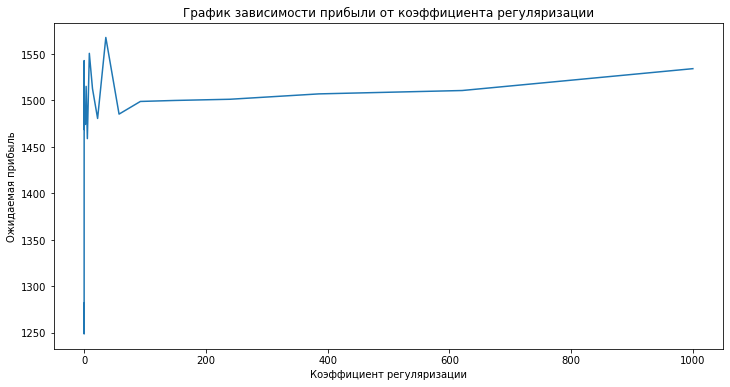

In [120]:
plt.figure(figsize = (12, 6))
plt.plot(grid, profits)
plt.title('График зависимости прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
;

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [121]:
best_lambdas = []
profits_all = []
for i in range(3):
    best_lambda, profits = find_best_lambda(X, y, grid, random_state = 123, expected = True)
    best_lambdas.append(best_lambda)
    profits_all.append(profits)

In [122]:
best_lambdas

[22.122162910704503, 0.04520353656360243, 621.0169418915616]

Как мы видим, мы провели кросс-валидацию 4 раза (считая первый выше) и каждый раз получается новый коэффициент, поэтому в целом нет, не находится каждый раз один и тот же коэффициент. Посмотрим на графики:

''

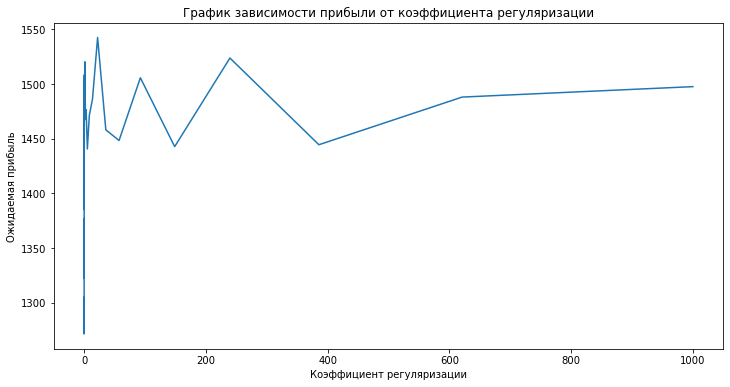

In [123]:
plt.figure(figsize = (12, 6))
plt.plot(grid, profits_all[0])
plt.title('График зависимости прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
;

''

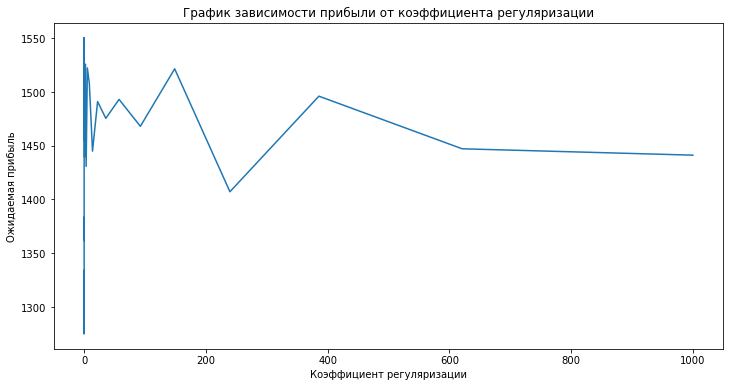

In [124]:
plt.figure(figsize = (12, 6))
plt.plot(grid, profits_all[1])
plt.title('График зависимости прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
;

''

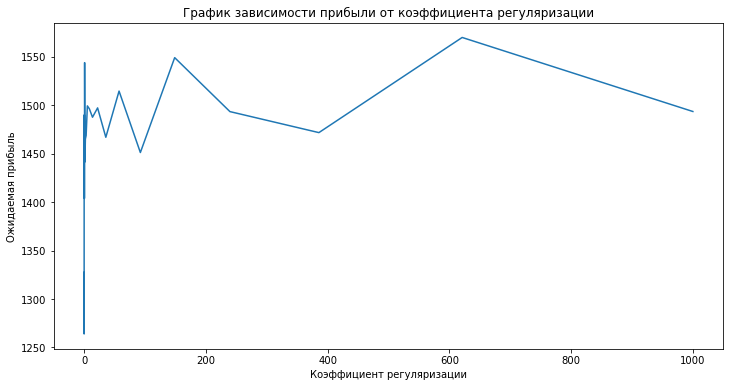

In [125]:
plt.figure(figsize = (12, 6))
plt.plot(grid, profits_all[2])
plt.title('График зависимости прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
;

Если нужно выделить какую-то закономерность, то это скорее всего похожий вид зависимости ожидаемой прибыли от коэффициентов. Вне зависимости от конкретных значений, ожидаемая прибыль все-таки в среднем будет примерно одинаковой, отсюда и схожая форма, но все же в данных есть случайность, поэтому максимум то выскакивает в начале списка (как в первых двух случаях), то ближе к середине, то может появиться и в конце.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В нашей задаче для нас плохо предсказывать 1, когда реальное значение 0, т.к. в таком случае мы понесем убытки, то есть мы можем упустить каких-то клиентов, но для нас гораздо важнее, чтобы те, кого мы отнесли к целевому классу согласились на услугу. Таким образом, в нашей задаче важнее хороший precision.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [126]:
from tqdm import tqdm
def find_best_t(
    X,
    y,
    grid_t,
    n_splits = 5,
    random_state = None,
    shuffle = True,
    expected = False
):
    profits = []
    precisions = []
    stds = []
    for t in tqdm(grid_t):
        stats = cross_validate(X, y, random_state = 123, expected = True, t = t)
        profits.append(stats['profit'].mean())
        precisions.append(stats['precision'].mean())
        stds.append(stats['profit'].std())
    best_t = grid_t[np.array(profits).argmax()]
    return best_t, profits, precisions, stds

In [127]:
grid_t = np.arange(0, 1.01, 0.01)
best_t, profits, precisions, stds = find_best_t(X, y, grid_t, random_state = 123, expected = True)

100%|█████████████████████████████████████████| 101/101 [13:51<00:00,  8.23s/it]


In [130]:
print(f'Порог, при котором бизнес-метрика максимальная: {best_t}')
print(f'Precision, соответствующий лучшему порогу: {precisions[17]}')
print(f'Максимально возможный precision: {max(precisions)}')

Порог, при котором бизнес-метрика максимальная: 0.17
Precision, соответствующий лучшему порогу: 0.4047393026637479
Максимально возможный precision: 0.8545672751859366


Как мы видим, по сути результат получился противоположный: оптимальным оказался довольно низкий порог, на нем далеко не самый высокий precision, и так как мы знаем, что с уменьшением порога растет recall, то скорее всего в задаче важнее именно эта метрика. Возможно это связано с тем, что доходы, которые мы получаем с согласного клиента сильно выше расходов за звонок не туда, поэтому если мы обзвоним как можно больше согласных клиентов, то выручка с них покроет расходы на ошибочные звонки и позволит извлечь максимальную прибыль.

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог




''

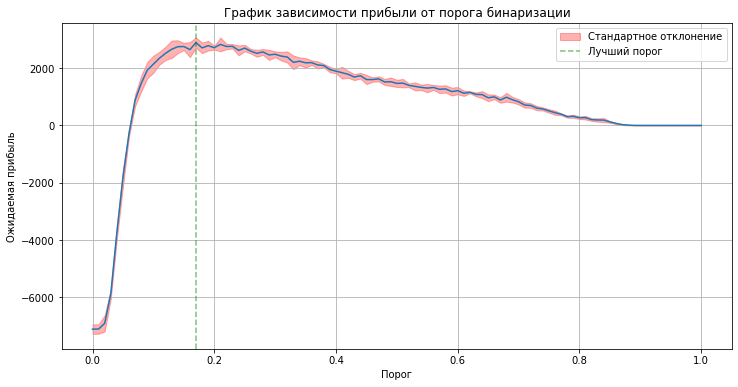

In [129]:
plt.figure(figsize = (12, 6))
plt.plot(grid_t, profits)
plt.title('График зависимости прибыли от порога бинаризации')
plt.xlabel('Порог')
plt.ylabel('Ожидаемая прибыль')
plt.fill_between(grid_t, np.array(profits) - np.array(stds),
                 np.array(profits) + np.array(stds), alpha=0.3, label='Стандартное отклонение', color = 'red')
plt.grid()
plt.axvline(best_t, ls = '--', color = 'green', alpha = 0.5, label = 'Лучший порог')
plt.legend()
;

Если что, функцию fill_between для того, чтобы показать std, украл у GPT.

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Запустив код несколько раз можно заметить, что всегда порог довольно низкий (0.15-0.2). И после достижения этого порога, с его увеличением прибыль начинает постепенно сокращаться к нулю. Как я уже сказал, скорее всего так получается из-за большой разницы выигрыша и проигрыша от звонка, мы почти ничего не теряем в случае неудачи, поэтому нам важнее именно охватить как можно больше клиентов, которые согласятся

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$)

Мы видели, что оптимальный коэффициент регуляризации менялся, поэтому возьмем тот, который получился в первый раз (35.6), как если бы мы его перебирали. А вот порог возьмем из предыдущего пункта, так как он всегда примерно один и тот же.

In [131]:
stats_new = cross_validate(X, y, lambda_ = 35.622478902624444, t = best_t, random_state = 123, expected = True)
profit_new = stats_new['profit'].mean()
std_new = stats_new['profit'].std()

stats_default = cross_validate(X, y, random_state = 123, expected = True)
profit_default = stats_default['profit'].mean()
std_default = stats_default['profit'].std()

In [132]:
from scipy import stats as sts
sts.ttest_ind_from_stats(profit_new, std_new, 5,
                         profit_default, std_default, 5)

Ttest_indResult(statistic=12.786584052288271, pvalue=1.3196642300700281e-06)

На самом деле я немного сомневаюсь, нужно ли за число наблюдений считать именно число фолдов, по которым мы среднее считаем, или размер тестовой выборки, но в любом случае даже для 5 наблюдений p-value очень низкий, а с ростом наблюдений p-value будет только сокращаться. В общем нулевая гипотеза отвергается, а значит, мы получили значимый результат, ура!

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [133]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [134]:
df = pd.read_csv(path)[features + [target]]
df.head()

,Marital status,Course,Nacionality,Gender,Age at enrollment,Target
0,1,2,1,1,20,Dropout
1,1,11,1,1,19,Graduate
2,1,5,1,1,19,Dropout
3,1,15,1,0,20,Graduate
4,2,3,1,0,45,Graduate


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Marital status     4424 non-null   int64 
 1   Course             4424 non-null   int64 
 2   Nacionality        4424 non-null   int64 
 3   Gender             4424 non-null   int64 
 4   Age at enrollment  4424 non-null   int64 
 5   Target             4424 non-null   object
dtypes: int64(5), object(1)
memory usage: 207.5+ KB


In [136]:
cats = ['Marital status', 'Course', 'Nacionality', 'Gender']
numeric = ['Age at enrollment']
df[cats] = df[cats].astype(str)

def transform_target(value):
    if value == 'Dropout':
        return 0
    elif value == 'Graduate':
        return 1
    else:
        return 2
    
df['Target'] = df['Target'].apply(transform_target)

In [137]:
df.head(3)

,Marital status,Course,Nacionality,Gender,Age at enrollment,Target
0,1,2,1,1,20,0
1,1,11,1,1,19,1
2,1,5,1,1,19,0


In [138]:
X = df.drop(columns = 'Target')
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

In [139]:
# кодируем категориальные признаки
encoder = OneHotEncoder(sparse = False, drop = 'first', handle_unknown="ignore")
X_train_cats = encoder.fit_transform(X_train[cats])
X_test_cats = encoder.transform(X_test[cats])
encoded_columns = encoder.get_feature_names(cats)

X_train_cats = pd.DataFrame(X_train_cats, columns=encoded_columns)
X_train = pd.concat([X_train_cats, X_train[numeric].reset_index(drop=True)], axis=1)
X_test_cats = pd.DataFrame(X_test_cats, columns=encoded_columns)
X_test = pd.concat([X_test_cats, X_test[numeric].reset_index(drop=True)], axis=1)

# масштабируем числовой признак
scaller = RobustScaler()
X_train[numeric] = scaller.fit_transform(X_train[numeric])
X_test[numeric] = scaller.transform(X_test[numeric])

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей, они нам пригодятся позже


В качестве метрики конечно не хочется использовать что-то типо accuracy, на лекции нам рассказывали про усреднение на примере precision и recall, поэтому давайте возьмем f1-меру. Также у нас есть небольшой дисбаланс в таргете, поэтому будем считать макро-усреднение.

In [140]:
df['Target'].value_counts() # объектов класса 2 почти в 3 раза меньше чем класса 1.

1    2209
0    1421
2     794
Name: Target, dtype: int64

In [141]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import f1_score
estimator = LogisticRegression(max_iter = 10000, random_state = 123)

In [142]:
start = time.time()

model_OVR = OneVsRestClassifier(estimator = estimator)
model_OVR.fit(X_train, y_train)
pred_OVR = model_OVR.predict(X_test)
pred_proba_OVR = model_OVR.predict_proba(X_test)

stop = time.time()

In [143]:
num_est_OVR = len(model_OVR.estimators_)
score_OVR = f1_score(y_test, pred_OVR, average = 'macro')
print(f'Число классификаторов для OVR: {num_est_OVR}')
print(f'Время обучения для OVR: {stop - start}')
print(f'F-1 мера для OVR: {score_OVR}')

Число классификаторов для OVR: 3
Время обучения для OVR: 0.10271906852722168
F-1 мера для OVR: 0.397388694690007


In [144]:
start = time.time()

model_OVO = OneVsOneClassifier(estimator = estimator)
model_OVO.fit(X_train, y_train)
pred_OVO = model_OVO.predict(X_test)
pred_proba_OVO = model_OVO.decision_function(X_test)

stop = time.time()

In [145]:
num_est_OVO = len(model_OVO.estimators_)
score_OVO = f1_score(y_test, pred_OVO, average = 'macro')
print(f'Число классификаторов для OVO: {num_est_OVO}')
print(f'Время обучения для OVO: {stop - start}')
print(f'F-1 мера для OVO: {score_OVO}')

Число классификаторов для OVO: 3
Время обучения для OVO: 0.06068992614746094
F-1 мера для OVO: 0.41289614567714855


Как вы объясните полученные результаты?

__Ответ:__ Число классификаторов в данном случае совпадает, так как при n = 3, $\dfrac{n(n-1)}{2} = n$

По времени обучения OVO работает чуть-чуть быстрее, но это тоже скорее всего только для нашего случая. При больших n, конечно, метод обучает намного больше моделей, чем OVR.

Что касается качества, то здесь OVO работает опять чуть лучше. В принципе это вряд ли как-то можно обьяснить, мне кажется, что в зависимости от задачи каждый метод может оказаться лучше. Можно разве что сказать, что OVO сам по себе более сложный метод, здесь в отличие от OVR каждый класс отдельно сравнивается с остальными и в общем случае это должно хорошо работать

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [10]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [14]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true, num_classes=n_classes) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [17]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данныъ, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаорита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ кашку :)